In [1]:
!pip install cellpose
!pip install plotly --upgrade
%pip install -q ipywidgets==8.0.4

#@title SETUP{ display-mode: "form" }
#@markdown Check if you are using Cellpose. If you are using Cellpose for your analysis, it is highly recommended to change runtype to "GPU". CPU-based segmentation will be 10x slower.
CELLPOSE = True #@param {type:"boolean"}

#System
import os.path
import glob
from pathlib import Path
from tqdm.notebook import tqdm
import io as io_
import ast
import random
import datetime
from datetime import date

#Data structure
import pandas as pd
import numpy as np
import pickle

#Image Processing
if CELLPOSE == True:
    import cellpose
    from cellpose import models, plot, utils
from PIL import Image
from skimage import io, filters, data, feature, exposure, measure, morphology
from ipywidgets import *
import ipywidgets as widgets
from scipy.spatial import distance
from cellpose import utils
import cellpose


#Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as pe
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Learning
from sklearn.metrics import pairwise_distances

from matplotlib.colors import LinearSegmentedColormap
GFP = [(0,0,0),(1,1,1)] #this is actually red, but I dont feel like going back and fixing it
GFP_cmap = LinearSegmentedColormap.from_list('GFP-cmap', GFP, N=256)

Note: you may need to restart the kernel to use updated packages.


In [2]:
def create_folders(base_path, expID, date):
    """Creates necessary folders for the experiment."""
    experiment_folder = f"{base_path}/{date}_{expID}"
    paths = {
        "base": experiment_folder,
        "segmentations": f"{experiment_folder}/segmentations",
        "analysis": f"{experiment_folder}/analysis",
        "output_figure": f"{experiment_folder}/output_figure",
        "mask": f"{experiment_folder}/mask",
    }
    for path in paths.values():
        Path(path).mkdir(parents=True, exist_ok=True)
    return paths

In [3]:
def run_cellpose(path, model, flow_threshold, diameter):
    """Runs Cellpose model on a given image."""
    rep_image = io.imread(path)[60]  # Frame 60 for segmentation
    post_mask, flows, styles, diams = model.eval(rep_image, channels=[0, 0], flow_threshold=flow_threshold, diameter=diameter)
    return post_mask, rep_image

In [4]:
def save_mask(mask, mask_folder, sample_number):
    """Saves the segmentation mask."""
    mask_filename = f"{mask_folder}/{sample_number}_mask.npy"
    np.save(mask_filename, mask)

In [5]:
def plot_segmentation_overlay(rep_image, post_mask, output_path, sample_number):
    """
    Plots segmentation overlay with ROI labels.
    This function displays and saves the segmentation overlay image.
    """
    outlines = utils.outlines_list(post_mask)
    fig, ax1 = plt.subplots(figsize=[5, 5])
    plt.imshow(rep_image, cmap='gray')  # Display the image in grayscale for clarity
    for i, o in enumerate(outlines):
        o_x = [e[0] for e in o]
        o_y = [e[1] for e in o]
        plt.text(np.mean(o_x), np.mean(o_y), f'{i + 1}', color='white', fontsize=8)
        plt.plot(o[:, 0], o[:, 1], color='white', linewidth=0.5)
    ax1.axis('off')
    
    segmentation_folder = os.path.join(output_path, "segmentations")
    os.makedirs(segmentation_folder, exist_ok=True)
    save_path = os.path.join(segmentation_folder, f"{sample_number[-2:]}_ROI_Overlay.pdf")
    plt.savefig(save_path, dpi=400, bbox_inches="tight")
    save_path_png = save_path.replace(".pdf", ".png")
    plt.savefig(save_path_png, dpi=400, bbox_inches="tight")
    plt.show()

In [6]:
def time_series_analysis(image_stack, post_mask, num_baseline_frames):
    """Analyzes the fluorescence time series for each ROI."""
    output_df = pd.DataFrame()
    output_df_for_printing = pd.DataFrame()

    for roi in tqdm(np.unique(post_mask)[1:], desc='ROIs'):
        roi_intensity = []
        frame_list = []
        for I, frame in enumerate(image_stack):
            roi_mask = post_mask == roi
            roi_intensity.append(np.round(np.mean(frame[roi_mask]), 2))
            frame_list.append(I)
        
        baseline = np.mean(roi_intensity[:num_baseline_frames])
        delta_f_over_f = [100 * ((e - baseline) / baseline) for e in roi_intensity]

        output_df = pd.concat([output_df, pd.DataFrame({
            'ROI': [roi] * len(delta_f_over_f),
            'Frame': frame_list,
            '∆F/F (%)': delta_f_over_f,
            'max ∆F/F (%)': [max(delta_f_over_f)] * len(delta_f_over_f)
        })])

        output_df_for_printing = pd.concat([output_df_for_printing, pd.DataFrame({
            'ROI': [roi],
            'max ∆F/F (%)': [max(delta_f_over_f)],
            'Baseline': [baseline]
        })])
    
    return output_df, output_df_for_printing

In [7]:
def save_analysis_results(output_df, output_df_for_printing, paths, sample_number):
    """Saves analysis results to CSV files."""
    output_df_for_printing = output_df_for_printing.sort_values(by='max ∆F/F (%)', ascending=False)
    output_df_for_printing.to_csv(f"{paths['analysis']}/{sample_number[-2:]}_delta_f_over_f_analysis.csv", index=False)
    
    df_for_saving = pd.DataFrame({
        str(roi): output_df[output_df['ROI'] == roi]['∆F/F (%)'].values
        for roi in output_df['ROI'].unique()
    })
    df_for_saving.to_csv(f"{paths['analysis']}/{sample_number[-2:]}_delta_f_over_f_raw.csv", index=False)


In [8]:
def plot_analysis_results(rep_image, post_mask, output_df, output_df_for_printing, paths, sample_number):
    """
    Plots the analysis results with a 2x3 grid layout:
    - Segmentation image spans 2 rows and 2 columns.
    - Time series and table vertically stacked in 1 column with equal height.
    """
    top_rois = output_df_for_printing['ROI'][:5].values
    top_delta_fs = output_df_for_printing['max ∆F/F (%)'][:5].values

    sns.set_theme(style='white', font_scale=1.5)
    color_palette = ['#fb4918', '#fb9800', '#0082a5', '#c8d200', '#ade5e5']

    # Create the figure with constrained layout
    fig = plt.figure(figsize=[15, 10])  # Adjust overall figure size
    gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[2, 2, 1], height_ratios=[2, 2], wspace=0.4, hspace=0.5)

    # Subplot 1: Segmentation image (spans 2 rows and 2 columns)
    ax1 = fig.add_subplot(gs[:, :2])
    ax1.imshow(rep_image, cmap='gray', vmax=1000)
    ax1.axis('off')

    for I, (roi, delta_f) in enumerate(zip(top_rois, top_delta_fs)):
        roi_mask = post_mask == roi
        outlines = utils.outlines_list(roi_mask.astype(np.int32))
        for o in outlines:
            ax1.plot(o[:, 0], o[:, 1], color=color_palette[I], linewidth=2)
            # Annotate ROI numbers
            o_x = [e[0] for e in o]
            o_y = [e[1] for e in o]
            ax1.text(np.mean(o_x), np.mean(o_y), f'{roi}', color=color_palette[I], fontsize=10,
                     path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    # Subplot 2: Time series plot (top row, right column)
    ax2 = fig.add_subplot(gs[0, 2])
    sns.lineplot(data=output_df, x='Frame', y='∆F/F (%)', color='slategray', label='Avg', ax=ax2)
    for I, roi in enumerate(top_rois):
        sns.lineplot(data=output_df[output_df['ROI'] == roi], x='Frame', y='∆F/F (%)', 
                     color=color_palette[I], label=f"ROI {roi}", ax=ax2)

    ax2.set_xlabel('Frames')
    ax2.set_ylabel('∆F/F (%)')
    sns.move_legend(ax2, "upper left", bbox_to_anchor=(1.05, 1.0))

    # Subplot 3: Table for Top 5 ROI (bottom row, right column)
    ax3 = fig.add_subplot(gs[1, 2])
    output_df_for_printing = output_df_for_printing[:5].round(2)
    col_labels = ['ROI', 'Max ∆F/F (%)', 'Baseline']
    cell_text = output_df_for_printing.values.tolist()
    ax3.axis('off')

    # Adjust table font size and scale to match the subplot height
    table = ax3.table(cellText=cell_text, colLabels=col_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)  # Adjust font size
    table.scale(1.5, 2)  # Adjust table scale for matching height

    # Save and show
    plt.savefig(f"{paths['output_figure']}/{sample_number[-2:]}_analysis_with_table_v3.pdf", dpi=300, bbox_inches="tight")
    plt.show()


c:\PyMOL\envs\Imaging\lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

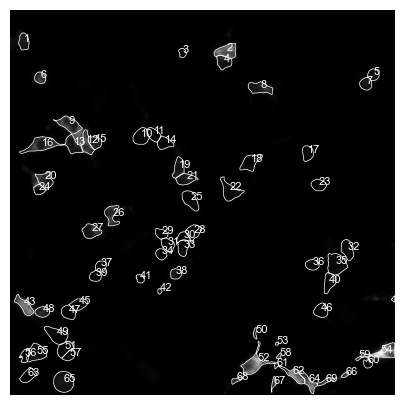

ROIs:   0%|          | 0/69 [00:00<?, ?it/s]

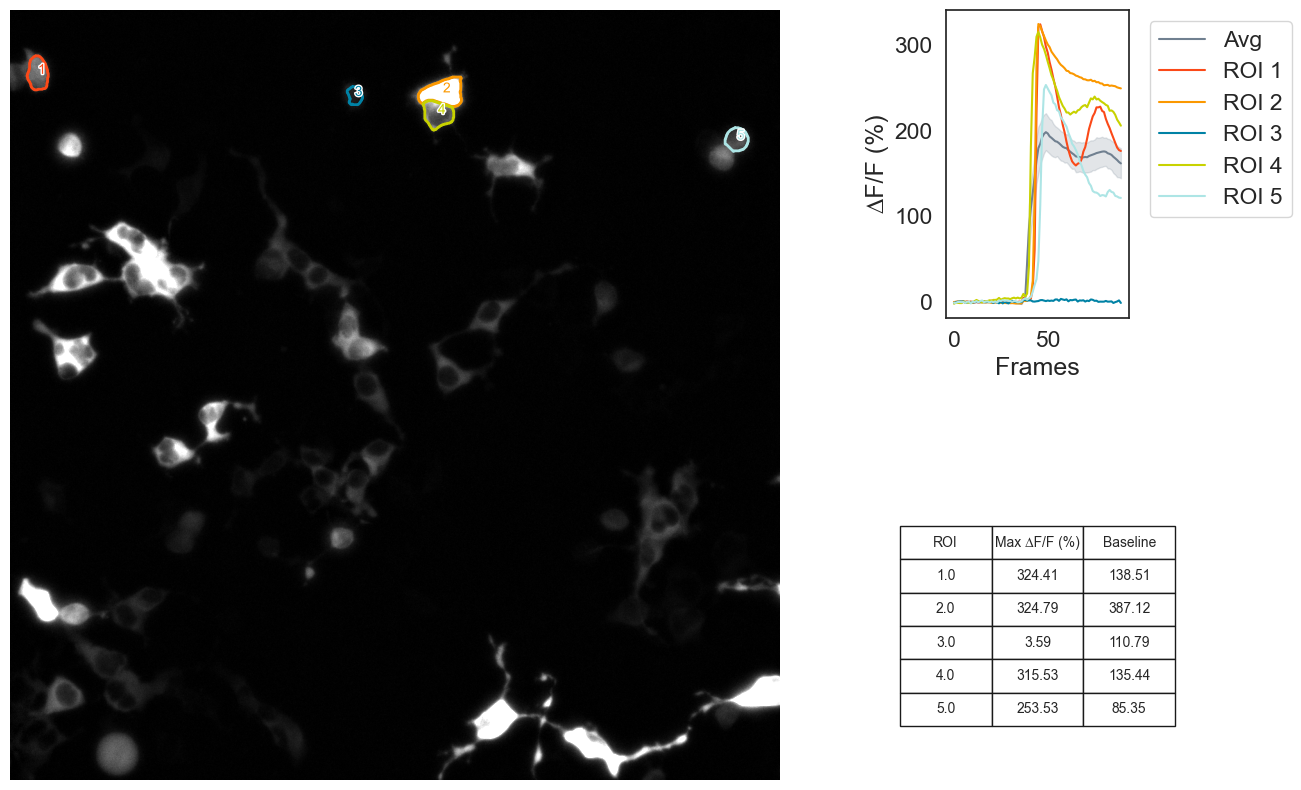

c:\PyMOL\envs\Imaging\lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

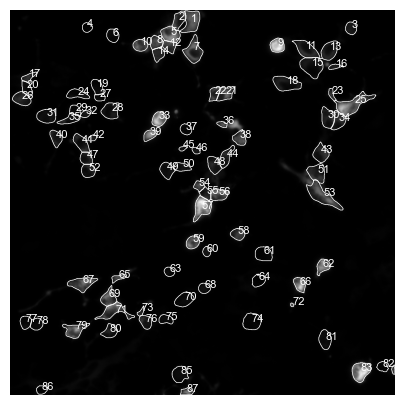

ROIs:   0%|          | 0/87 [00:00<?, ?it/s]

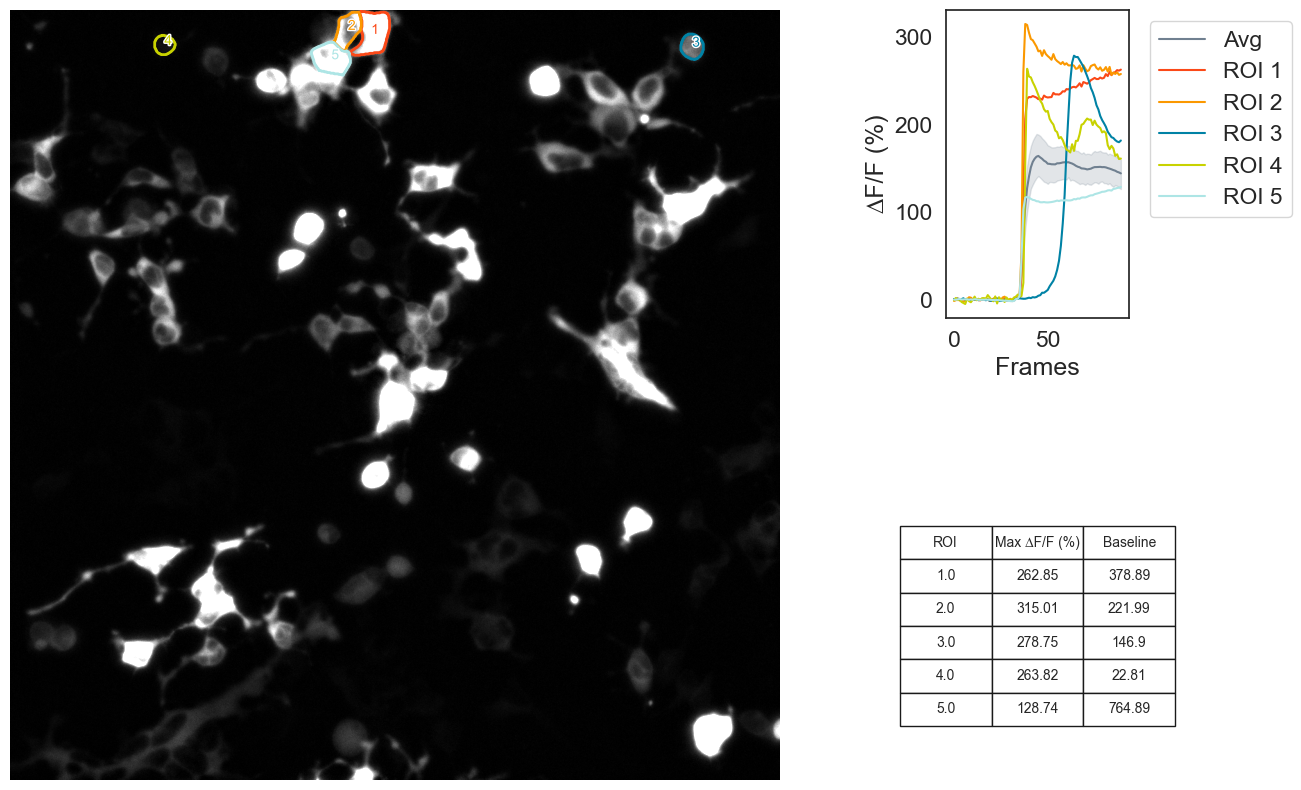

c:\PyMOL\envs\Imaging\lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

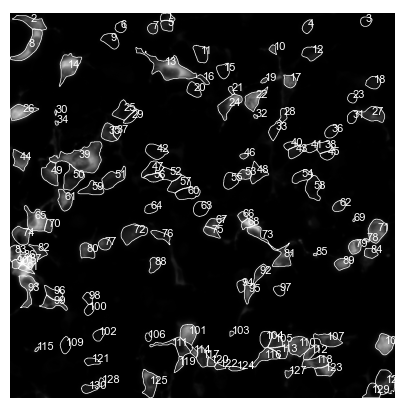

ROIs:   0%|          | 0/130 [00:00<?, ?it/s]

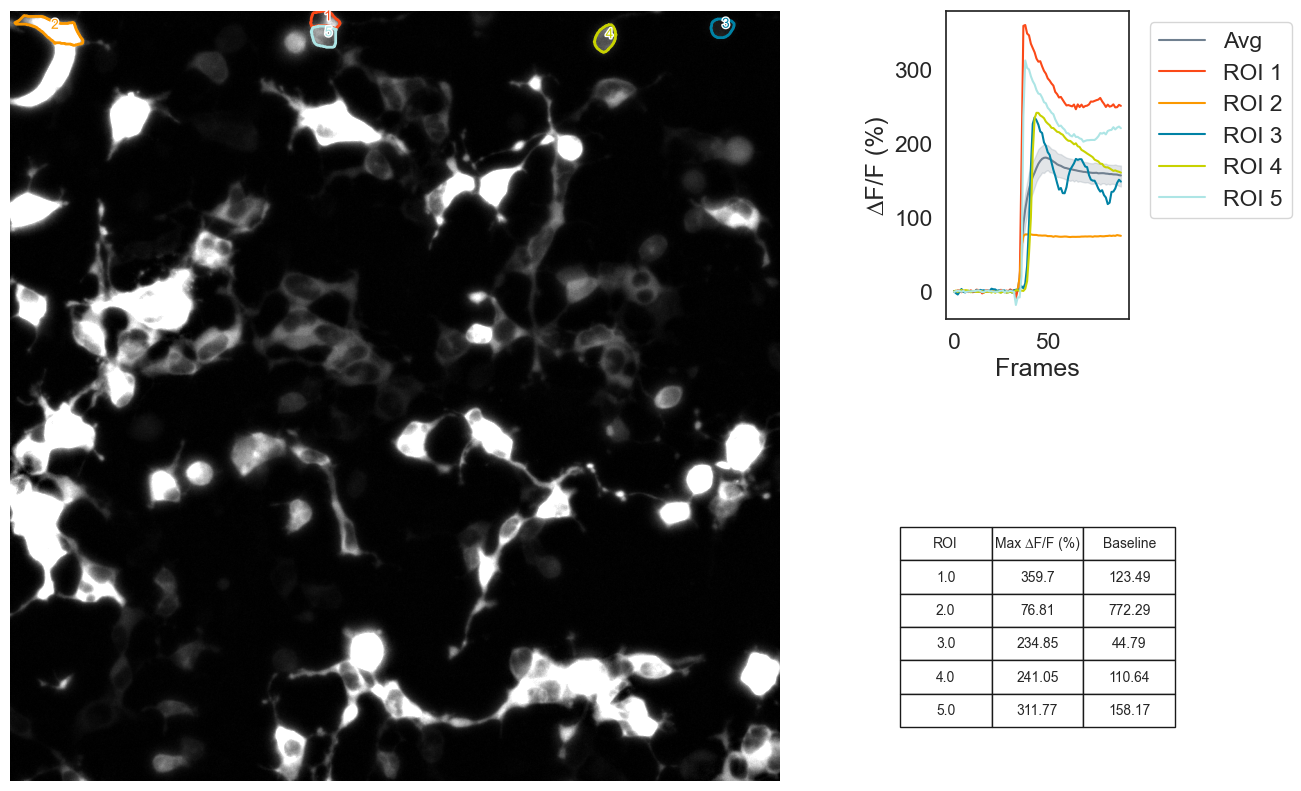

c:\PyMOL\envs\Imaging\lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

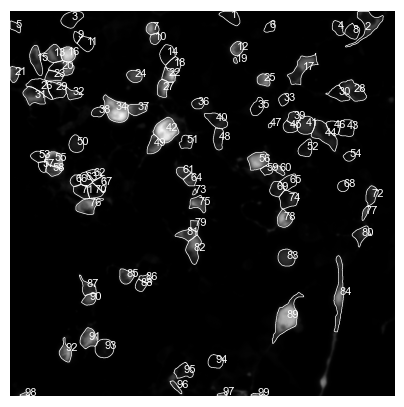

ROIs:   0%|          | 0/99 [00:00<?, ?it/s]

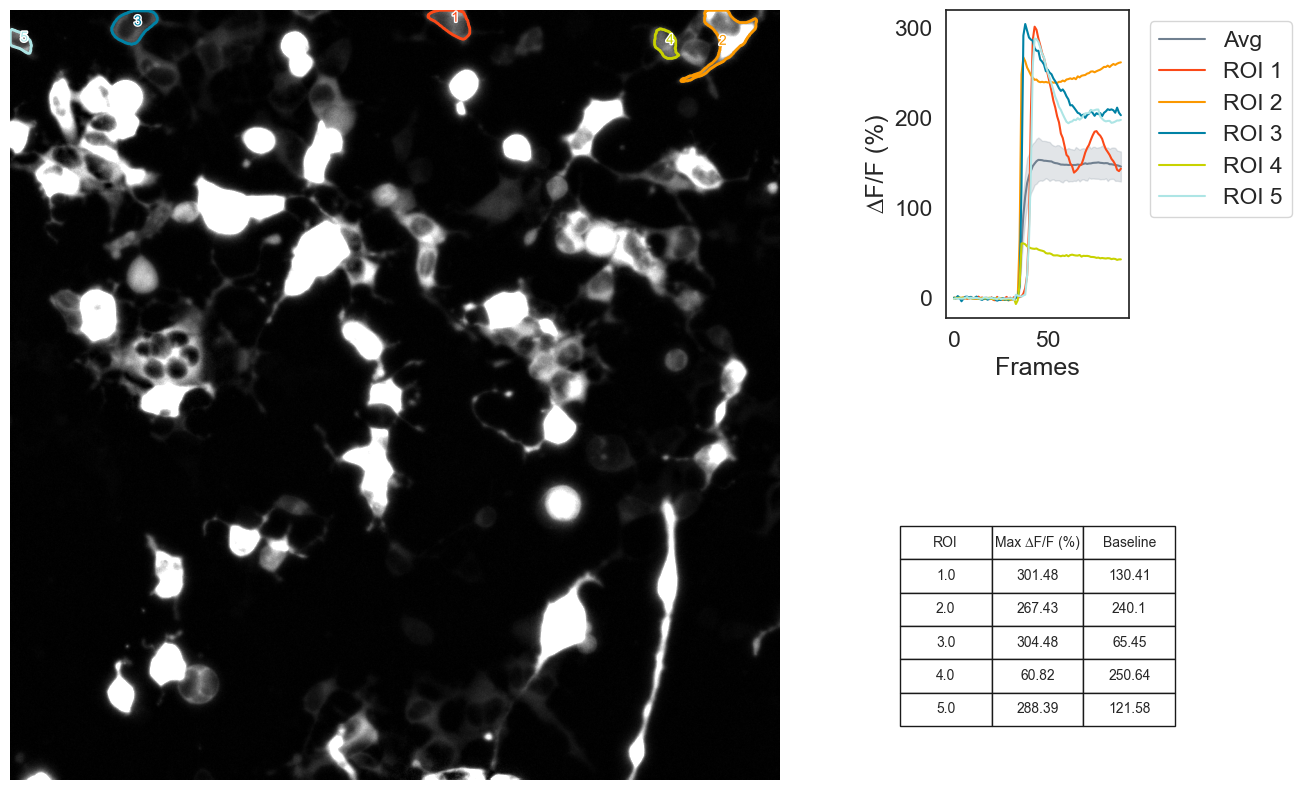

c:\PyMOL\envs\Imaging\lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, map_location=torch.devi

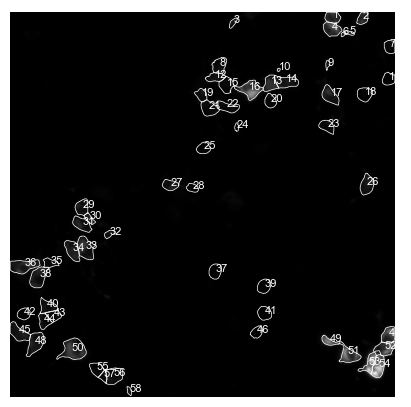

ROIs:   0%|          | 0/58 [00:00<?, ?it/s]

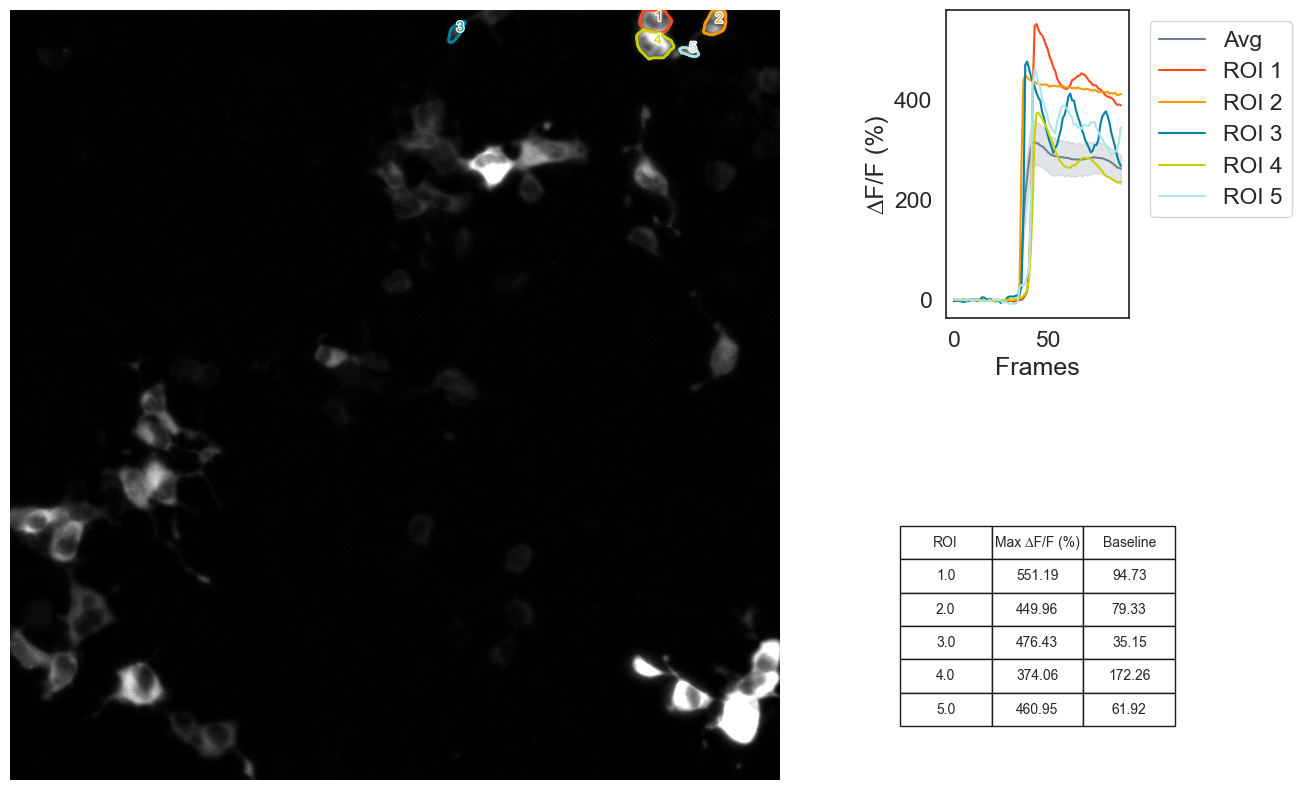

In [17]:
def main():
    # Experiment configuration
    expID = "CP_segementation_and_analysis"
    num_baseline_frames = 20 # set the baseline frames!!!
    min_size = 1000
    flow_threshold = 0.4
    mask_threshold = 0.0
    rescale = 1
    diameter = None
    base_path = os.path.abspath(os.curdir)
    date = datetime.date.today().isoformat()

    # Create folders
    paths = create_folders(base_path, expID, date)

    # Loop through samples
    for sample_number in [f"{i:02}" for i in range(61,66)]: # change the samples numbers!!!
        sample_name = f"BS50/sample_{sample_number}"
        path = sample_name + '.tif'

        # Initialize Cellpose model
        model = models.Cellpose(gpu='use_GPU', model_type='cyto3')

        # Segmentation
        post_mask, rep_image = run_cellpose(path, model, flow_threshold, diameter)
        save_mask(post_mask, paths['mask'], sample_number)
        plot_segmentation_overlay(rep_image, post_mask, paths['base'], sample_number)

        # Analysis
        image_stack = io.imread(path)
        output_df, output_df_for_printing = time_series_analysis(image_stack, post_mask, num_baseline_frames)
        save_analysis_results(output_df, output_df_for_printing, paths, sample_number)
        plot_analysis_results(rep_image, post_mask, output_df, output_df_for_printing, paths, sample_number)

if __name__ == "__main__":
    main()
